# COMPSCI 371D Homework 6

Write the names of all contributors to this assignment here:

+ ...
+ ...

## Part 1: Automatic Differentiation

### Automatic Differentiation Basics

In [40]:
_names = {}

def reset_auto_diff(name=None):
    global _names
    if name is None:
        _names = {}
    else:
        _names.pop(name, None)

In [41]:
class Node:
    def __init__(self, value, gradient=None, name=None, variables=None):
        self.value = value
        self.gradient = gradient
        self.name = name
        self.variables = variables

In [42]:
class Internal(Node):
    def __init__(self, value, gradient, variables):
        super(Internal, self).__init__(value, gradient=gradient, name=None,
                                       variables=variables)

    def __str__(self):
        grad_string = 'Gradient wrt {}:\n{}'.format(self.variables, self.gradient)
        return '{}\n{}'.format(self.value, grad_string)

In [43]:
class Variable(Node):
    def __init__(self, value, name):
        assert name not in _names, 'Different independent variables must have different name'
        assert isinstance(value, int) or isinstance(value, float), 'Variables must be scalars'
        value = float(value)
        _names[name] = name
        gradient = [1.0]
        super(Variable, self).__init__(value, gradient=gradient, name=name, variables=[name])

    def __str__(self):
        return '{}:\n{}'.format(self.name, self.value)

In [44]:
def print_variables(*args, **keywords):
    try:
        print(keywords['title'])
    except KeyError:
        pass
    print(*args, sep='\n\n', end='\n\n')

In [45]:
def scale_list(sequence, factor):
    return [factor * item for item in sequence]

### A Botched Implementation of `times`

In [46]:
def bad_times(a, b):
    assert isinstance(a, Node) and isinstance(b, Node)
    value = a.value * b.value
    a_gradient = scale_list(a.gradient, b.value)
    b_gradient = scale_list(b.gradient, a.value)
    # The following two + are list concatenation operators
    gradient = a_gradient + b_gradient
    variables = a.variables + b.variables
    return Internal(value, gradient, variables)

In [47]:
reset_auto_diff()

u = Variable(2.0, 'u')
v = Variable(4.0, 'v')
print_variables(u, v)

p = bad_times(u, v)
print_variables(p, title='product')

s = bad_times(u, u)
print_variables(s, title='square')

u:
2.0

v:
4.0

product
8.0
Gradient wrt ['u', 'v']:
[4.0, 2.0]

square
4.0
Gradient wrt ['u', 'u']:
[2.0, 2.0]



### Problem 1.1

### Solution

In [48]:
def merge(*partials):
    gradients = {}
    for arg in partials:
        (g,v) = arg
        for i in range(len(g)):
            if v[i] in gradients:
                gradients[v[i]] += g[i]
            else:
                gradients[v[i]] = g[i]
    return list(gradients.values()), list(gradients.keys())

print (merge(([2,3],["x","v"]),([3,4],["x","n"])))


([5, 3, 4], ['x', 'v', 'n'])


### Problem 1.2

### Solution

In [49]:
# Your solution in this celldef plus(a, b):
def times(a, b):

    assert isinstance(a, Node) and isinstance(b, Node)
    value = a.value * b.value
    a_gradient = scale_list(a.gradient, b.value)
    b_gradient = scale_list(b.gradient, a.value)
    # The following two + are list concatenation operators
    gradient, variables = merge((a_gradient, a.variables), (b_gradient, b.variables))
    return Internal(value, gradient, variables)

def plus(a, b):

    assert isinstance(a, Node) and isinstance(b, Node)
    value = a.value + b.value
#     a_gradient = scale_list(a.gradient, b.value)
#     b_gradient = scale_list(b.gradient, a.value)
    # The following two + are list concatenation operators
    gradient, variables = merge((a.gradient, a.variables), (b.gradient, b.variables))
    return Internal(value, gradient, variables)

In [50]:
# reset_auto_diff()

# u = Variable(2.0, 'u')
# v = Variable(4.0, 'v')
# print_variables(u, v)

# z = plus(u, v)
# print_variables(z, title='sum')

# twice = plus(u, u)
# print_variables(twice, title='twice')

### Problem 1.3

### Solution

In [51]:
### Solution
import math

def cosine(x):
    
    value = math.cos(x.value)
    gradient = scale_list(x.gradient, -1 * math.sin(x.value))
    variable = x.variables
    
    return Internal(value, gradient, variable)
    

def sine(x):
    value = math.sin(x.value)
    gradient = scale_list(x.gradient, math.cos(x.value))
    variable = x.variables
    
    return Internal(value, gradient, variable)

def one(x):
    value = plus(times(cosine(x), cosine(x)), times(sine(x), sine(x))) 
    
    
    return value
    
def derivative(a, name):
    return a.gradient[a.variables.index(name)]

reset_auto_diff()
print (one(Variable(3, 'x')))

0.9999999999999999
Gradient wrt ['x']:
[0.0]


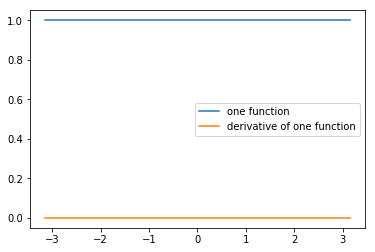

In [52]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-np.pi, np.pi, num=100)
reset_auto_diff()

y1 = []
y2 = []
for i in range(len(x)):
    reset_auto_diff()
    x_val = Variable(x[i], 'x')
    one_node = one(x_val)
    y1.append(one_node.value)
    y2.append(derivative(one_node, 'x'))
    
plt.plot(x, y1, label="one function")
plt.plot(x, y2, label="derivative of one function")
plt.legend()

plt.show()

### Problem 1.4

### Solution

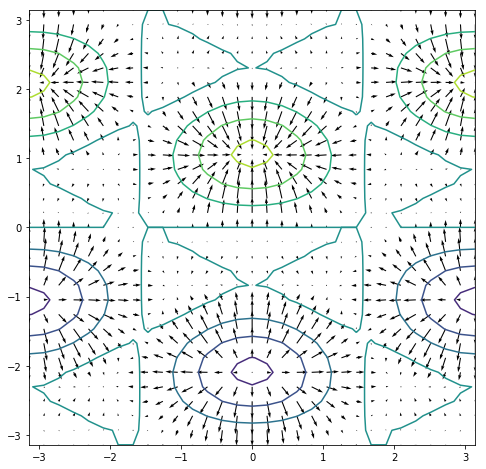

In [53]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_gradient(f, trange=(-np.pi, np.pi), samples=31):
    t = np.linspace(trange[0], trange[1], samples)
    x_values, y_values = np.meshgrid(t, t)
    z_values = np.zeros_like(x_values)
    g_x = np.zeros((samples, samples))
    g_y = np.zeros((samples, samples))
    reset_auto_diff(name='pg_x')
    reset_auto_diff(name='pg_y')
    x = Variable(0.0, 'pg_x')
    y = Variable(0.0, 'pg_y')
    for i in range(samples):
        for j in range(samples):
            x.value, y.value = x_values[i, j], y_values[i, j]
            z = f(x, y)
            z_values[i, j] = z.value
            g_x[i, j], g_y[i, j] = derivative(z, 'pg_x'), derivative(z, 'pg_y')

    plt.figure(figsize=(8, 8))
    plt.contour(t, t, z_values)
    plt.quiver(t, t, g_x, g_y)
    plt.show()

def trig(x, y):
    a = times(cosine(x), sine(y))
    b = plus(cosine(x), sine(plus(y, y)))
    value = times(a, b)
    return value

plot_gradient(trig)

## Part 2: Loss and Convexity

### Problem 2.1

### Solution

### Problem 2.2 (Exam-Style)

### Solution

## Part 3: Logistic Regression and Regularization

In [54]:
import autograd.numpy as np
from autograd import grad, jacobian

In [55]:
def logistic(x, v):
    alpha = v[0] + v[1] * x
    return 1.0 / (1.0 + np.exp(-alpha))

In [56]:
import pickle
with open('data.pickle', 'rb') as file:
    T = pickle.load(file)

### Problem 3.1

### Solution

90.82010299827601


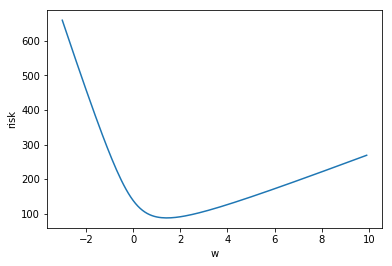

In [57]:
def risk(v, T):
    risk = 0
    small = 1.e-8
    for i in range(0,len(T['x'])):
        logistic_value = logistic(T['x'][i],v)
        p = np.minimum(1.0 - small, np.maximum(small, logistic_value))
        loss = (-1) * (T['y'][i]*np.log(p)) - (1-T['y'][i])*np.log(1-p)
        risk += loss
    return risk

print (risk([0,1],T))
 
def plot_risks(T, risk=risk):
    x = np.arange(-3,10, 0.1)
    y = risk([0,x],T)
    plt.xlabel("w")
    plt.ylabel("risk")
    plt.plot(x,y)
    plt.show()

plot_risks(T)

### Problem 3.2

### Solution

(0.22, 90.82010299827601)


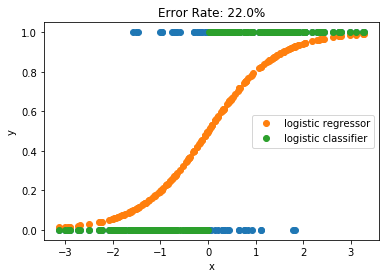

None


In [64]:
def classifier(x, v):
    newlist = []
    for item in x:
        newlist.append(round(logistic(item,v)))
    return np.asarray(newlist)


def performance(v, T):
    
    classifications = classifier(T['x'],v)
            
    zerooneloss = 0
    
    for i in range(0,len(T['y'])):
        if T['y'][i] != classifications[i]:
            zerooneloss += 1
    
    zeroonelossfinal = zerooneloss/float(len(T['y']))
            
        
    
    regrisk = risk(v,T)
    
    return (zeroonelossfinal,regrisk)

print(performance([0,1], T))

# def plot_logistic_regressor(v, T):
    
def logisticarray(x,v):
    newlist = []
    for item in x:
        value = logistic(item,v)
        newlist.append(value)
    return np.asarray(newlist)
        
    
    
    
def plot_logistic_regressor(v, T):
    
    figsize=(8, 4)
    
    x = T['x']
    y1 = T['y']
    y2 = logisticarray(T['x'],v)
    y3 = classifier(T['x'],v)
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.plot(x,y1,'o')
    plt.plot(x,y2,'o',label='logistic regressor')
    plt.plot(x,y3,'o', label='logistic classifier')
    plt.title("Error Rate: {}%".format(performance(v, T)[0] * 100))
    plt.legend()
    plt.show()
    
print (plot_logistic_regressor([0,1.4], T))


### Problem 3.3

### Solution

In [59]:
from scipy.optimize import minimize
def learn_logistic_regressor(T, lambda_reg=0.0):
    risk_T = lambda v: risk(v, T) + lambda_reg * np.inner(v, v)
    gradient = grad(risk_T)
    hessian = jacobian(gradient)
    output = minimize(risk_T, np.array([0.0, 0.0]), jac=gradient, hess=hessian)
    if(output['success']):
        b = output['x'][0]
        w = output['x'][1]
        iterations = output['nit']
        print('b: {0:4f}'.format(b))
        print('w: {0:4f}'.format(w))
        print('lambda_reg: {0}'.format(lambda_reg))
        print('iterations: {0}'.format(iterations))
        return b, w, lambda_reg, iterations
    else:
        print(output['message'])
        return None
    print(output)
    
v_star = learn_logistic_regressor(T)
print(v_star)

b: -0.009478
w: 1.429870
lambda_reg: 0.0
iterations: 9
(-0.009478329414227308, 1.4298700660519916, 0.0, 9)


### Problem 3.4

### Solution

b: -0.009478
w: 1.429870
lambda_reg: 0.0
iterations: 9
spread 0.0


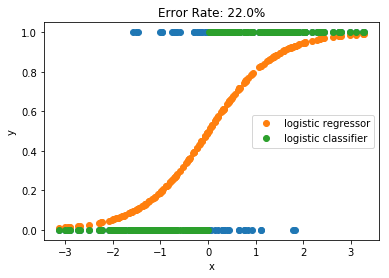

b: -0.007010
w: 3.281175
lambda_reg: 0.0
iterations: 15
spread 1.0


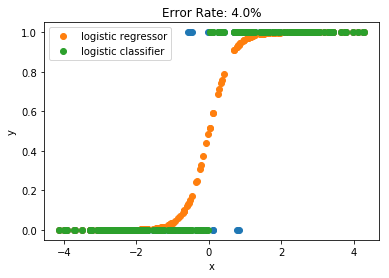

b: -1.794429
w: 2.033059
lambda_reg: 0.0
iterations: 15
spread 10.0


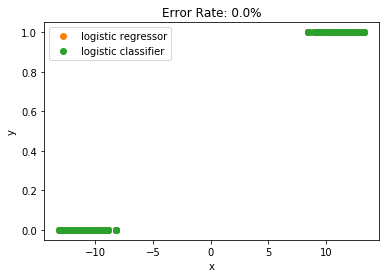

In [65]:
def spread_data(T, spread=0.0):
    x, y = T['x'].copy(), T['y'].copy()
    for i in range(len(x)):
        if y[i] == 0:
            x[i] -= spread
        else:
            x[i] += spread
    
    return { 'x': x, 'y': y }

def spread_experiment(lambda_reg):
    for spread in [0.0, 1.0, 10.0]:
        T_s = spread_data(T, spread)
        b,w,_,_ = learn_logistic_regressor(T_s, lambda_reg)
        v_s = [b, w]
        print('spread', spread)
        plot_logistic_regressor(v_s, T_s)

spread_experiment(0.0)
        

### Problem 3.5

### Solution

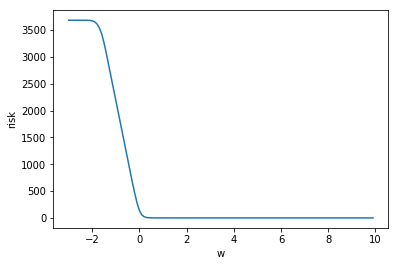

In [66]:
T_10 = spread_data(T, spread=10.0)
plot_risks(T_10)

### Problem 3.6 (Exam-Style)

### Solution

### Problem 3.7

### Solution

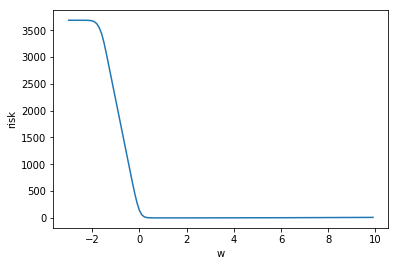

In [83]:
T_10 = spread_data(T, spread=10.0)
lambda_reg = 0.1
risk_T_10 = lambda v, T: risk(v, T) + lambda_reg * np.inner(np.array(v), np.array(v))
plot_risks(T_10, risk=risk_T_10)